In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib

In [ ]:
df = pd.read_csv('/Users/pranav/Downloads/CyberSecurity/MDPI-Vehicles/Datasets/DoS_dataset.csv')
df.columns = ['Timestamp', 'CAN ID', 'DLC', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']
df.head()

In [ ]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df.head()

In [ ]:
df.nunique()

In [ ]:
df_2 = df.copy()

In [ ]:
# Identify invalid hex values
hex_columns = ['CAN ID', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7']
invalid_hex = {}

for col in hex_columns:
    invalid_values = df_2[~df_2[col].astype(str).apply(is_valid_hex)][col].unique()
    if len(invalid_values) > 0:
        invalid_hex[col] = invalid_values

# Display invalid hex values if any
if invalid_hex:
    print("\nColumns with Invalid Hex Values:")
    for col, values in invalid_hex.items():
        print(f"{col}: {values[:10]}")  # Show first 10 invalid values
else:
    print("\nAll hex columns have valid values.")



In [33]:
import pandas as pd

# List of datasets
datasets = [
    'Fuzzy_dataset.csv',
    'RPM_dataset.csv',
    'gear_dataset.csv'
]

# Base path
base_path = '/kaggle/input/car-hacking-dataset/'

# Function to process each dataset
def process_dataset(file_name):
    print(f"\nProcessing: {file_name}")
    
    # Load dataset
    df = pd.read_csv(base_path + file_name)
    
    # Rename columns
    df.columns = ['Timestamp', 'CAN ID', 'DLC', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']
    
    # Convert Timestamp to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    
    # Check for missing values
    print("\nMissing Values:\n", df.isnull().sum())
    
    # Check unique values in categorical/numeric columns
    print("\nUnique Values in DLC and Flag:\n", df[['DLC', 'Flag']].nunique())
    
    # Function to validate hexadecimal values
    def is_valid_hex(value):
        """Check if a string is a valid hexadecimal value."""
        try:
            int(value, 16)  # Convert to integer with base 16
            return True
        except (ValueError, TypeError):
            return False

    # Identify invalid hex values
    hex_columns = ['CAN ID', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7']
    invalid_hex = {}

    for col in hex_columns:
        invalid_values = df[~df[col].astype(str).apply(is_valid_hex)][col].unique()
        if len(invalid_values) > 0:
            invalid_hex[col] = invalid_values

    # Display invalid hex values if any
    if invalid_hex:
        print("\nColumns with Invalid Hex Values:")
        for col, values in invalid_hex.items():
            print(f"{col}: {values[:10]}")  # Show first 10 invalid values
    else:
        print("\nAll hex columns have valid values.")

# Process each dataset
for dataset in datasets:
    process_dataset(dataset)




Processing: Fuzzy_dataset.csv

Missing Values:
 Timestamp        0
CAN ID           0
DLC              0
DATA0            0
DATA1            0
DATA2            0
DATA3        34382
DATA4        34382
DATA5        34382
DATA6        87833
DATA7        87836
Flag         87836
dtype: int64

Unique Values in DLC and Flag:
 DLC     4
Flag    2
dtype: int64

Columns with Invalid Hex Values:
DATA2: ['R']
DATA3: [nan]
DATA4: [nan]
DATA5: ['R' nan]
DATA6: [nan 'R']
DATA7: [nan]

Processing: RPM_dataset.csv

Missing Values:
 Timestamp        0
CAN ID           0
DLC              0
DATA0            0
DATA1            0
DATA2            0
DATA3        41476
DATA4        41476
DATA5        41476
DATA6        41476
DATA7        41476
Flag         41476
dtype: int64

Unique Values in DLC and Flag:
 DLC     2
Flag    2
dtype: int64

Columns with Invalid Hex Values:
DATA2: ['R']
DATA3: [nan]
DATA4: [nan]
DATA5: [nan]
DATA6: [nan]
DATA7: [nan]

Processing: gear_dataset.csv

Missing Values:
 Timestamp 

In [27]:
df.nunique()

Timestamp    2813
CAN ID         27
DLC             2
DATA0         108
DATA1          71
DATA2          75
DATA3          26
DATA4         190
DATA5         256
DATA6          75
DATA7         256
Flag            2
dtype: int64

In [25]:
df['DLC'].unique()

array([8, 2])

In [14]:
df[df['DLC'] == 2].count()

Timestamp    31188
CAN ID       31188
DLC          31188
DATA0        31188
DATA1        31188
DATA2        31188
DATA3            0
DATA4            0
DATA5            0
DATA6            0
DATA7            0
Flag             0
dtype: int64

In [3]:
df['CAN ID'].unique()

array(['018f', '0260', '02a0', '0329', '0545', '0002', '0153', '02c0',
       '0130', '0131', '0140', '0350', '043f', '0370', '0440', '0316',
       '04f0', '0430', '04b1', '01f1', '05f0', '00a0', '00a1', '0690',
       '05a0', '05a2', '0000'], dtype=object)

In [4]:
df['DATA0'].unique()

array(['fe', '19', '64', '40', 'd8', '00', '14', '08', 'e5', '05', 'ff',
       '04', '29', '0b', '0e', '01', '24', '0f', '12', '5c', '80', '44',
       '10', '11', '86', '15', '18', '17', 'fb', 'f7', '13', '09', 'dc',
       'ee', '0d', '07', '20', '0c', '16', 'f2', '06', '1b', '1e', '1d',
       'e0', '0a', 'db', 'e9', '25', '22', '21', '1f', '1a', '7f', '23',
       'd2', '03', 'd7', '02', '3b', 'c9', '7e', '2e', '32', '27', '26',
       '5e', '5f', 'fa', '1c', '62', '63', '81', '82', '83', '61', '60',
       '50', '5d', '5b', '28', '5a', '7d', '7c', '59', 'ce', '58', 'fd',
       '37', '7b', '7a', '84', '85', '2a', 'c5', 'f9', '2b', '2d', 'f6',
       'c0', '30', '79', '78', '2f', '87', '57', 'bb', '45'], dtype=object)

In [5]:
df['DATA1'].unique()

array(['5b', '21', '00', 'bb', '80', '7f', '20', '40', '27', '84', '89',
       '59', '22', 'bc', '85', '58', '5a', '5c', 'bd', '57', 'be', '86',
       'bf', '5d', '87', '23', '5f', '88', '60', '5e', '56', '54', '53',
       '24', '25', '26', '61', '66', '67', '65', '62', '63', 'ba', '83',
       'b9', '82', 'b8', 'b7', '81', 'b6', 'b5', 'b4', '8a', '64', '51',
       '52', '55', '50', '4f', 'b3', '7e', 'c0', '69', '68', '4c', '4b',
       '4d', '8b', '4e', '4a', '49'], dtype=object)

In [26]:
df['DATA2'].unique()

array([  0.,  34., 154., 127.,  16.,  20.,  96., 104.,  39.,  36.,  nan,
        52.,  33.,  68.,  84., 100., 116., 132., 148., 164., 180., 196.,
       212., 228., 244.,   4., 108.,  92., 120., 112.,   1., 165., 124.,
        88.,  80., 128.,  35., 136., 155., 160., 156., 168., 172., 192.,
        37., 204., 208., 220., 216., 232., 224., 236., 252., 240., 248.,
        12.,   8.,  28.,  24.,  32.,  40.,  38.,  48.,  44.,  56.,  72.,
        60.,  64.,  76., 200., 188., 140., 152., 144., 176., 184.])

In [6]:
invalid_hex = [x for x in df['DATA2'] if not all(c in '0123456789abcdefABCDEF' for c in str(x))]
count = len(invalid_hex)
count


31188

In [7]:
df.nunique()

Timestamp    3665770
CAN ID            27
DLC                2
DATA0            108
DATA1             71
DATA2             76
DATA3             26
DATA4            190
DATA5            256
DATA6             75
DATA7            256
Flag               2
dtype: int64

In [40]:
df.shape

(3634582, 12)

In [39]:
df = df[df['DATA2'].apply(lambda x: all(c in '0123456789abcdefABCDEF' for c in x))]


In [41]:
df['DATA2'].unique()

array(['00', '22', '9a', '7f', '10', '14', '60', '68', '27', '24', '34',
       '21', '44', '54', '64', '74', '84', '94', 'a4', 'b4', 'c4', 'd4',
       'e4', 'f4', '04', '6c', '5c', '78', '70', '01', 'a5', '7c', '58',
       '50', '80', '23', '88', '9b', 'a0', '9c', 'a8', 'ac', 'c0', '25',
       'cc', 'd0', 'dc', 'd8', 'e8', 'e0', 'ec', 'fc', 'f0', 'f8', '0c',
       '08', '1c', '18', '20', '28', '26', '30', '2c', '38', '48', '3c',
       '40', '4c', 'c8', 'bc', '8c', '98', '90', 'b0', 'b8'], dtype=object)

In [23]:
df['DATA3'].unique()

array(['00', '30', '1d', '14', '8a', 'ff', '68', '09', '80', '23', '88',
       '89', '8b', '01', '87', '83', '84', '81', '82', '7f', '7e', '0a',
       '85', '86', '8c', '7d'], dtype=object)

In [24]:
df['DATA4'].unique()

array(['00', '08', '97', '11', '31', '48', '77', '7e', 'ff', '21', '45',
       '38', '0a', '37', '30', '0c', '24', '76', '36', '0e', '1d', '46',
       '10', '22', 'a0', '1f', '55', '12', '52', '14', 'eb', '16', 'e5',
       '3d', '18', '3f', '1a', '34', '42', '02', '04', '23', '06', 'df',
       '15', 'e0', '29', '33', '1c', '3b', 'f1', '3a', '40', '2d', '20',
       '0d', '0b', '01', 'f5', '41', '4c', '2a', '4a', 'f0', '3e', '1e',
       '32', '2b', '1b', '2e', '39', '19', '2c', '44', '09', '51', '0f',
       '26', '4b', '13', '27', 'fe', '43', 'fa', '4f', 'fc', '2f', '35',
       '28', 'ea', 'f4', '4e', 'fb', 'f8', '54', '3c', '47', '4d', 'f9',
       '53', '58', 'f3', '17', '5e', '05', '7d', '07', '5b', '25', '5a',
       'f7', 'ee', 'ec', '49', 'e7', '56', '5c', 'e8', 'ed', '59', 'e6',
       '65', '6a', 'f2', '60', 'e1', '66', '5f', 'd0', 'd9', 'dc', 'd4',
       'e4', '61', '78', 'e3', '50', 'dd', '62', 'd7', '72', '70', '6d',
       '63', 'de', 'd6', '03', '68', '69', '75', '6

In [42]:
df['DATA5'].unique()

array(['3c', '8e', '02', '20', '00', '03', 'ff', '80', '7f', '22', 'ce',
       '21', '69', 'd0', '23', 'cd', '1f', 'ca', '28', 'c9', '33', '24',
       'c8', 'c6', '04', 'c4', 'c7', '05', 'c3', '25', 'c5', '27', '06',
       'bf', '29', 'c0', '32', 'c2', '07', '08', '12', '0f', '14', '13',
       '0d', 'c1', '09', 'cb', 'cc', '26', '0a', '2f', '0b', 'cf', '01',
       'd1', 'd2', 'd3', 'd5', 'd4', 'd6', 'd7', 'd9', 'd8', 'da', 'bd',
       'be', 'bb', 'bc', 'db', 'dd', 'ba', 'b9', 'b8', 'b7', 'df', 'dc',
       'de', 'b6', '7e', 'e0', '3d', 'e5', 'e6', 'e8', '3e', 'eb', 'ec',
       'ed', 'f9', 'fe', 'fb', '3f', '10', '18', '40', '1b', '1e', '41',
       '2c', '31', '38', '39', '3a', '36', '3b', '44', '43', '48', '49',
       '4d', '4e', '50', '52', '59', '57', '55', '5a', '58', '6a', '8f',
       '6c', '6e', '6f', '70', '72', '73', '74', '71', '6d', '68', '65',
       '6b', '75', '76', '78', '7c', '7d', '7b', '81', '82', '84', '83',
       '87', '88', '86', '85', '7a', '79', '77', '8

In [26]:
df['DATA6'].unique()

array(['00', '6d', 'bd', '0b', '2b', '08', 'd1', '0c', '2c', '0d', '2d',
       '02', '0e', '2e', '0f', '2f', '71', '20', '01', '21', '70', '22',
       '03', '23', '04', '24', '6e', '05', '25', '06', '26', '07', '27',
       '28', '09', '29', '0a', '2a', '6f', '6c', '69', '6a', '68', '6b',
       '73', '72', '74', '67', '66', '76', '77', '75', '65', '7d', '7b',
       '81', '7e', '80', '84', '82', '64', '62', '63', '78', '7a', '79',
       '7c', '87', '85', '86', '7f', '83', '61', '60', '5f'], dtype=object)

In [27]:
df['DATA7'].unique()

array(['00', '3a', '14', '11', '7f', 'ac', 'a3', '2e', '6f', '07', '13',
       '9a', '42', '1e', '85', '9b', '27', '18', '5f', 'ba', '88', 'a7',
       '0e', '2a', '78', '65', '9d', 'cf', 'c8', '01', '6e', '03', 'de',
       '5e', 'd6', 'd2', '83', 'c3', '45', 'fb', '4e', '26', 'e4', 'be',
       '99', '64', 'df', '37', 'f9', '86', 'e6', 'ae', '04', 'aa', '9e',
       'bb', '6d', 'ee', '17', 'dc', '1c', '92', '8e', '28', '69', 'fe',
       'ce', 'b0', '39', '74', 'f7', '06', '0c', '43', '77', '25', 'b9',
       '3e', '9f', 'db', '36', 'a4', '70', '50', '1a', '97', '98', '15',
       'ea', '68', '75', 'cd', '7e', '2f', '23', '24', '80', '40', 'bf',
       '0b', 'b4', 'e8', 'a2', '08', 'cc', 'a6', '2d', '82', 'c0', 'b5',
       '48', 'cb', '29', '33', '3b', 'f1', 'c2', 'b8', 'ec', 'd1', 'd9',
       'c5', '1b', 'a9', 'b6', '57', '3c', 'd4', 'e7', '09', '51', '8c',
       '31', '61', 'f6', 'eb', '89', '8a', 'a5', '7d', '91', '4d', 'c6',
       'ca', '10', '6a', '4c', '0f', '30', 'e0', 'd

In [43]:
df.describe()

,Timestamp,DLC
count,3.634582e+06,3634582.0
mean,1.478200e+09,8.0
std,8.469984e+02,0.0
min,1.478198e+09,8.0
25%,1.478199e+09,8.0
50%,1.478200e+09,8.0
75%,1.478201e+09,8.0
max,1.478201e+09,8.0


In [44]:
df_2 = df.copy()
# Convert 'Timestamp' to datetime
df_2['Timestamp'] = pd.to_datetime(df_2['Timestamp'], unit='ms')

# Set Timestamp as the index
df_2 = df_2.set_index('Timestamp')

# Calculate time intervals between messages
df_2['Time_delta'] = df_2.index.to_series().diff()

# Count occurrences of '0000' CAN IDs in a 300ms rolling window
df_2['0000_Count'] = (df_2['CAN ID'] == '0000').astype(int).rolling('300ms').sum()

df_2.head()


,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag,Time_delta,0000_Count
Timestamp,,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,8,fe,5b,00,00,00,3c,00,00,R,NaT,0.0
1970-01-18 02:36:38.376389864,0260,8,19,21,22,30,08,8e,6d,3a,R,0 days 00:00:00.000000228,0.0
1970-01-18 02:36:38.376390096,02a0,8,64,00,9a,1d,97,02,bd,00,R,0 days 00:00:00.000000232,0.0
1970-01-18 02:36:38.376390333,0329,8,40,bb,7f,14,11,20,00,14,R,0 days 00:00:00.000000237,0.0
1970-01-18 02:36:38.376390574,0545,8,d8,00,00,8a,00,00,00,00,R,0 days 00:00:00.000000241,0.0


In [46]:
df_2['Time_delta'] = df_2['Time_delta'].fillna(pd.Timedelta(seconds=0))  # Replace NaT with 0 seconds
df_2.head()

,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag,Time_delta,0000_Count
Timestamp,,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,8,fe,5b,00,00,00,3c,00,00,R,0 days 00:00:00,0.0
1970-01-18 02:36:38.376389864,0260,8,19,21,22,30,08,8e,6d,3a,R,0 days 00:00:00.000000228,0.0
1970-01-18 02:36:38.376390096,02a0,8,64,00,9a,1d,97,02,bd,00,R,0 days 00:00:00.000000232,0.0
1970-01-18 02:36:38.376390333,0329,8,40,bb,7f,14,11,20,00,14,R,0 days 00:00:00.000000237,0.0
1970-01-18 02:36:38.376390574,0545,8,d8,00,00,8a,00,00,00,00,R,0 days 00:00:00.000000241,0.0


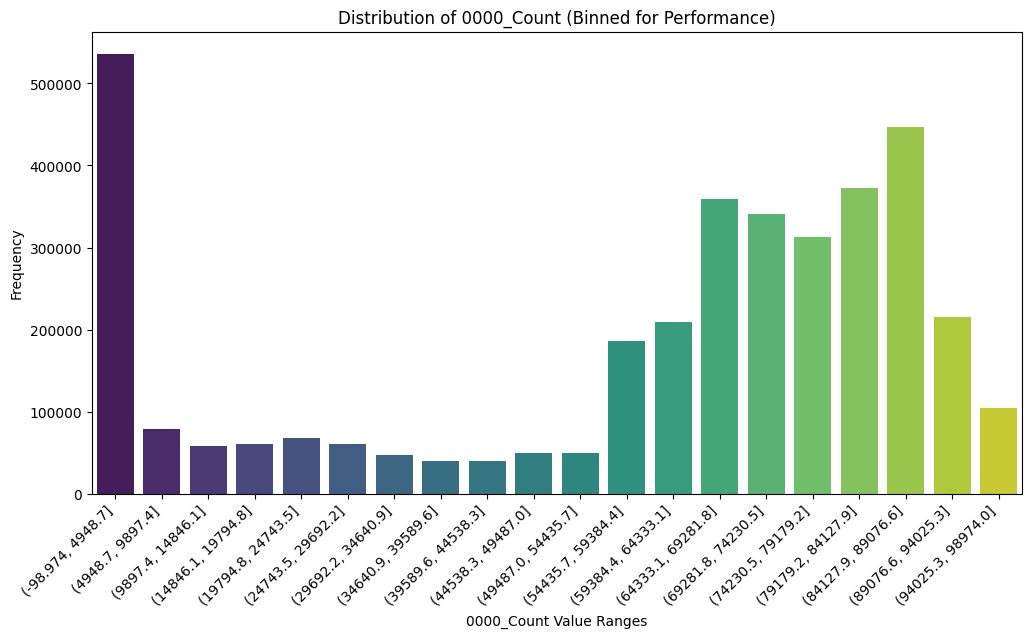

In [47]:


# Filter out 0 values and make a copy to avoid SettingWithCopyWarning
df_count = df_2.copy()

# Use bins for better performance
num_bins = 20  # Adjust based on data size
df_count["0000_Count_Binned"] = pd.cut(df_count["0000_Count"], bins=num_bins)

# Count occurrences of each bin
binned_counts = df_count["0000_Count_Binned"].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=binned_counts.index.astype(str), y=binned_counts.values, palette="viridis")

# Labels and formatting
plt.xlabel("0000_Count Value Ranges")
plt.ylabel("Frequency")
plt.title("Distribution of 0000_Count (Binned for Performance)")
plt.xticks(rotation=45, ha='right')

# Show plot
plt.show()




In [48]:
# Drop unnecessary columns
df_3 = df_2.drop(["DLC"], axis=1).copy()
df_3.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag,Time_delta,0000_Count
Timestamp,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,fe,5b,00,00,00,3c,00,00,R,0 days 00:00:00,0.0
1970-01-18 02:36:38.376389864,0260,19,21,22,30,08,8e,6d,3a,R,0 days 00:00:00.000000228,0.0
1970-01-18 02:36:38.376390096,02a0,64,00,9a,1d,97,02,bd,00,R,0 days 00:00:00.000000232,0.0
1970-01-18 02:36:38.376390333,0329,40,bb,7f,14,11,20,00,14,R,0 days 00:00:00.000000237,0.0
1970-01-18 02:36:38.376390574,0545,d8,00,00,8a,00,00,00,00,R,0 days 00:00:00.000000241,0.0


In [49]:
df_3.dtypes, df_3.shape

(CAN ID                 object
 DATA0                  object
 DATA1                  object
 DATA2                  object
 DATA3                  object
 DATA4                  object
 DATA5                  object
 DATA6                  object
 DATA7                  object
 Flag                   object
 Time_delta    timedelta64[ns]
 0000_Count            float64
 dtype: object,
 (3634582, 12))

In [50]:
df_2 = df.copy()

In [51]:
df_3.describe()

,Time_delta,0000_Count
count,3634582,3.634582e+06
mean,0 days 00:00:00.000000779,5.782381e+04
std,0 days 00:00:00.000011817,3.144320e+04
min,0 days 00:00:00,0.000000e+00
25%,0 days 00:00:00.000000239,3.479100e+04
50%,0 days 00:00:00.000000245,6.901500e+04
75%,0 days 00:00:00.000000300,8.194200e+04
max,0 days 00:00:00.022358267,9.897400e+04


In [52]:
# Move 'Flag' column to the end
df_3 = df_3[[
    col for col in df_3.columns if col != 'Flag'
] + ['Flag']]
df_3.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Time_delta,0000_Count,Flag
Timestamp,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,fe,5b,00,00,00,3c,00,00,0 days 00:00:00,0.0,R
1970-01-18 02:36:38.376389864,0260,19,21,22,30,08,8e,6d,3a,0 days 00:00:00.000000228,0.0,R
1970-01-18 02:36:38.376390096,02a0,64,00,9a,1d,97,02,bd,00,0 days 00:00:00.000000232,0.0,R
1970-01-18 02:36:38.376390333,0329,40,bb,7f,14,11,20,00,14,0 days 00:00:00.000000237,0.0,R
1970-01-18 02:36:38.376390574,0545,d8,00,00,8a,00,00,00,00,0 days 00:00:00.000000241,0.0,R


In [53]:
df_4 = df_3.copy()
# Function to convert hex to decimal
def hex_to_int(hex_str: str) -> int:
    try:
        return int(str(hex_str).strip(), 16)  # Convert hex to int
    except ValueError:
        return np.nan 

# Convert all DATA columns
for col in df_4.columns[1:-3]:  # Exclude 'Flag' column
    df_4[col] = df_4[col].apply(hex_to_int)

In [13]:
df_4.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Time_delta,0000_Count,Flag
Timestamp,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,254,91,0.0,0.0,0.0,60.0,0.0,0.0,0 days 00:00:00,0.0,R
1970-01-18 02:36:38.376389864,0260,25,33,34.0,48.0,8.0,142.0,109.0,58.0,0 days 00:00:00.000000228,0.0,R
1970-01-18 02:36:38.376390096,02a0,100,0,154.0,29.0,151.0,2.0,189.0,0.0,0 days 00:00:00.000000232,0.0,R
1970-01-18 02:36:38.376390333,0329,64,187,127.0,20.0,17.0,32.0,0.0,20.0,0 days 00:00:00.000000237,0.0,R
1970-01-18 02:36:38.376390574,0545,216,0,0.0,138.0,0.0,0.0,0.0,0.0,0 days 00:00:00.000000241,0.0,R


In [54]:
df_5 = df_4.copy()
df_5.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Time_delta,0000_Count,Flag
Timestamp,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,254,91,0,0,0,60,0,0,0 days 00:00:00,0.0,R
1970-01-18 02:36:38.376389864,0260,25,33,34,48,8,142,109,58,0 days 00:00:00.000000228,0.0,R
1970-01-18 02:36:38.376390096,02a0,100,0,154,29,151,2,189,0,0 days 00:00:00.000000232,0.0,R
1970-01-18 02:36:38.376390333,0329,64,187,127,20,17,32,0,20,0 days 00:00:00.000000237,0.0,R
1970-01-18 02:36:38.376390574,0545,216,0,0,138,0,0,0,0,0 days 00:00:00.000000241,0.0,R


In [55]:
df_5["Flag"] = df_4["Flag"].map({"R": 0, "T": 1})
df_5.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Time_delta,0000_Count,Flag
Timestamp,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,254,91,0,0,0,60,0,0,0 days 00:00:00,0.0,0
1970-01-18 02:36:38.376389864,0260,25,33,34,48,8,142,109,58,0 days 00:00:00.000000228,0.0,0
1970-01-18 02:36:38.376390096,02a0,100,0,154,29,151,2,189,0,0 days 00:00:00.000000232,0.0,0
1970-01-18 02:36:38.376390333,0329,64,187,127,20,17,32,0,20,0 days 00:00:00.000000237,0.0,0
1970-01-18 02:36:38.376390574,0545,216,0,0,138,0,0,0,0,0 days 00:00:00.000000241,0.0,0


In [56]:
print(df_4["Flag"].unique())

['R' 'T']


In [57]:
filtered_df2 = df_5[df_5["CAN ID"] == "0000"]
filtered_df2.head(), filtered_df2.shape

(                              CAN ID  DATA0  DATA1  DATA2  DATA3  DATA4  \
 Timestamp                                                                 
 1970-01-18 02:36:38.377185137   0000      0      0      0      0      0   
 1970-01-18 02:36:38.377185629   0000      0      0      0      0      0   
 1970-01-18 02:36:38.377186119   0000      0      0      0      0      0   
 1970-01-18 02:36:38.377186612   0000      0      0      0      0      0   
 1970-01-18 02:36:38.377187116   0000      0      0      0      0      0   
 
                                DATA5  DATA6  DATA7                Time_delta  \
 Timestamp                                                                      
 1970-01-18 02:36:38.377185137      0      0      0 0 days 00:00:00.000000238   
 1970-01-18 02:36:38.377185629      0      0      0 0 days 00:00:00.000000244   
 1970-01-18 02:36:38.377186119      0      0      0 0 days 00:00:00.000000239   
 1970-01-18 02:36:38.377186612      0      0      0 0 days 00

In [18]:
df_5.shape,df_5.dtypes

((3665770, 12),
 CAN ID                 object
 DATA0                   int64
 DATA1                   int64
 DATA2                 float64
 DATA3                 float64
 DATA4                 float64
 DATA5                 float64
 DATA6                 float64
 DATA7                 float64
 Time_delta    timedelta64[ns]
 0000_Count            float64
 Flag                  float64
 dtype: object)

In [19]:
df_5.isnull().sum()

CAN ID            0
DATA0             0
DATA1             0
DATA2         31188
DATA3         31188
DATA4         31188
DATA5         31188
DATA6         31188
DATA7         31188
Time_delta        0
0000_Count        0
Flag          31188
dtype: int64

In [58]:
df_6 = df_5.dropna().copy()
df_6.shape

(3634582, 12)

In [59]:
print(df_6["Flag"].unique())

[0 1]


In [60]:
df_6.isnull().sum(), df_6.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3634582 entries, 1970-01-18 02:36:38.376389636 to 1970-01-18 02:36:41.209058944
Data columns (total 12 columns):
 #   Column      Dtype          
---  ------      -----          
 0   CAN ID      object         
 1   DATA0       int64          
 2   DATA1       int64          
 3   DATA2       int64          
 4   DATA3       int64          
 5   DATA4       int64          
 6   DATA5       int64          
 7   DATA6       int64          
 8   DATA7       int64          
 9   Time_delta  timedelta64[ns]
 10  0000_Count  float64        
 11  Flag        int64          
dtypes: float64(1), int64(9), object(1), timedelta64[ns](1)
memory usage: 360.5+ MB


(CAN ID        0
 DATA0         0
 DATA1         0
 DATA2         0
 DATA3         0
 DATA4         0
 DATA5         0
 DATA6         0
 DATA7         0
 Time_delta    0
 0000_Count    0
 Flag          0
 dtype: int64,
 None)

In [61]:
# Convert columns to int64 including timestamp mcolumn
df_6 = df_6.astype({"DATA0": "int64", "DATA1": "int64",
                    "DATA2": "int64", "DATA3": "int64", "DATA4": "int64",
                    "DATA5": "int64", "DATA6": "int64", "DATA7": "int64",
                    "Time_delta": "int64", "0000_Count": "int64", "Flag": "int64"})

In [62]:
df_6.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Time_delta,0000_Count,Flag
Timestamp,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,254,91,0,0,0,60,0,0,0,0,0
1970-01-18 02:36:38.376389864,0260,25,33,34,48,8,142,109,58,228,0,0
1970-01-18 02:36:38.376390096,02a0,100,0,154,29,151,2,189,0,232,0,0
1970-01-18 02:36:38.376390333,0329,64,187,127,20,17,32,0,20,237,0,0
1970-01-18 02:36:38.376390574,0545,216,0,0,138,0,0,0,0,241,0,0


In [63]:
df_6.dtypes

CAN ID        object
DATA0          int64
DATA1          int64
DATA2          int64
DATA3          int64
DATA4          int64
DATA5          int64
DATA6          int64
DATA7          int64
Time_delta     int64
0000_Count     int64
Flag           int64
dtype: object

In [64]:
df_6.describe()

,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Time_delta,0000_Count,Flag
count,3.634582e+06,3.634582e+06,3.634582e+06,3.634582e+06,3.634582e+06,3.634582e+06,3.634582e+06,3.634582e+06,3.634582e+06,3.634582e+06,3.634582e+06
mean,5.095562e+01,3.774545e+01,3.063615e+01,5.449552e+01,3.922035e+01,5.668486e+01,2.197127e+01,4.089031e+01,7.793659e+02,5.782381e+04,1.616475e-01
std,8.836175e+01,5.223686e+01,5.322283e+01,8.867384e+01,6.830257e+01,7.719327e+01,5.266569e+01,6.758418e+01,1.181752e+04,3.144320e+04,3.681272e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.390000e+02,3.479100e+04,0.000000e+00
50%,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,2.450000e+02,6.901500e+04,0.000000e+00
75%,3.600000e+01,3.900000e+01,3.500000e+01,1.040000e+02,3.500000e+01,1.270000e+02,9.000000e+00,5.900000e+01,3.000000e+02,8.194200e+04,0.000000e+00
max,2.550000e+02,1.920000e+02,2.520000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.090000e+02,2.550000e+02,2.235827e+07,9.897400e+04,1.000000e+00


In [65]:
df_7 = df_6.copy()
df_7.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Time_delta,0000_Count,Flag
Timestamp,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,254,91,0,0,0,60,0,0,0,0,0
1970-01-18 02:36:38.376389864,0260,25,33,34,48,8,142,109,58,228,0,0
1970-01-18 02:36:38.376390096,02a0,100,0,154,29,151,2,189,0,232,0,0
1970-01-18 02:36:38.376390333,0329,64,187,127,20,17,32,0,20,237,0,0
1970-01-18 02:36:38.376390574,0545,216,0,0,138,0,0,0,0,241,0,0


In [66]:
filtered_df3 = df_7[(df_7["CAN ID"] == "0000")]
filtered_df3.shape

(587521, 12)

In [67]:
# Exclude the 'Flag' column before calculating correlation
correlation_matrix = df_7.drop(columns=['CAN ID','Flag', 'Time_delta', '0000_Count']).corr()
correlation_matrix

,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7
DATA0,1.000000,0.262622,-0.087865,-0.121826,0.301022,0.159252,-0.086027,-0.161409
DATA1,0.262622,1.000000,0.245918,0.246772,-0.002113,0.272086,-0.198364,0.192120
DATA2,-0.087865,0.245918,1.000000,0.146732,0.365238,-0.042852,0.307529,0.131026
DATA3,-0.121826,0.246772,0.146732,1.000000,0.141884,0.613955,0.017878,0.035810
DATA4,0.301022,-0.002113,0.365238,0.141884,1.000000,0.349199,0.191276,0.016340
DATA5,0.159252,0.272086,-0.042852,0.613955,0.349199,1.000000,0.064044,-0.036581
DATA6,-0.086027,-0.198364,0.307529,0.017878,0.191276,0.064044,1.000000,-0.081293
DATA7,-0.161409,0.192120,0.131026,0.035810,0.016340,-0.036581,-0.081293,1.000000


<Axes: >

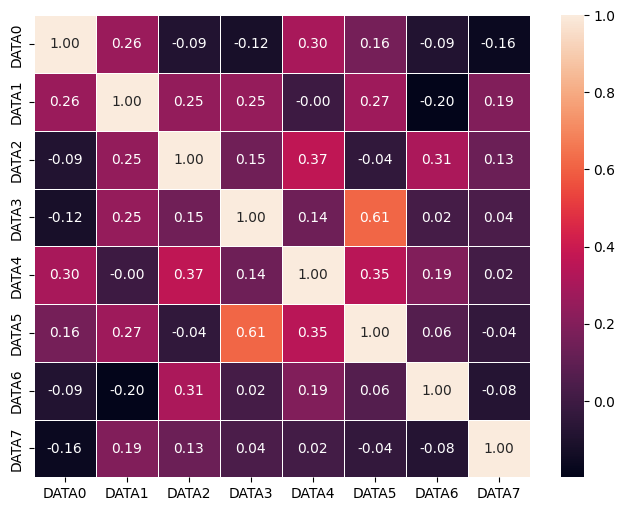

In [68]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', linewidths=0.5)

In [69]:
filtered_df4 = df_7[(df_7["Flag"] == 1) & (df_7["CAN ID"] == "0000")]
filtered_df4.shape

(587521, 12)

In [70]:
df_8 = df_7.copy()
# Load the dataset (assuming df_7 is already a DataFrame)
df_8['CAN ID'] = df_8['CAN ID'].apply(lambda x: int(x, 16))  # Convert hex to integer
df_8['CAN ID'] = df_8['CAN ID'].astype(int)
df_8.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Time_delta,0000_Count,Flag
Timestamp,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,399,254,91,0,0,0,60,0,0,0,0,0
1970-01-18 02:36:38.376389864,608,25,33,34,48,8,142,109,58,228,0,0
1970-01-18 02:36:38.376390096,672,100,0,154,29,151,2,189,0,232,0,0
1970-01-18 02:36:38.376390333,809,64,187,127,20,17,32,0,20,237,0,0
1970-01-18 02:36:38.376390574,1349,216,0,0,138,0,0,0,0,241,0,0


In [71]:
df_9 = df_8.drop(columns=['Time_delta', '0000_Count'], axis=1)
df_9 = df_9.reset_index(drop=True)
df_9.head(), df_9['Flag'].value_counts()

(   CAN ID  DATA0  DATA1  DATA2  DATA3  DATA4  DATA5  DATA6  DATA7  Flag
 0     399    254     91      0      0      0     60      0      0     0
 1     608     25     33     34     48      8    142    109     58     0
 2     672    100      0    154     29    151      2    189      0     0
 3     809     64    187    127     20     17     32      0     20     0
 4    1349    216      0      0    138      0      0      0      0     0,
 Flag
 0    3047061
 1     587521
 Name: count, dtype: int64)

In [72]:
import os
import pandas as pd
import numpy as np

# ✅ Detect GPU availability
GPU_AVAILABLE = os.path.exists('/dev/nvidia0')

try:
    if GPU_AVAILABLE:
        import cudf
        import cupy as cp
        from cuml.ensemble import RandomForestClassifier as cuRF
        from cuml.model_selection import train_test_split
        from cuml.preprocessing import StandardScaler as cuScaler
        print("🚀 RAPIDS cuML available! Running on GPU")
    else:
        raise ImportError
except ImportError:
    GPU_AVAILABLE = False
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestClassifier
    print("⚡ RAPIDS not available. Running on CPU.")

# 📌 Load dataset directly to GPU
if GPU_AVAILABLE:
    df_10 = cudf.from_pandas(df_9)
else:
    df_10 = df_9.copy()

# Define features and target
X = df_10.drop(columns=['Flag'])
y = df_10['Flag']

# ✅ Handle class imbalance (GPU-compatible)
if GPU_AVAILABLE:
    # Simplified GPU oversampling (adjust as needed)
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    X_0_resampled = X_0.sample(n=len(X_1), replace=True)
    X_resampled = cudf.concat([X_1, X_0_resampled])
    y_resampled = cudf.Series(cp.concatenate([cp.ones(len(X_1)), cp.zeros(len(X_0_resampled))]))
else:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

# ✅ Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Convert to float32
if GPU_AVAILABLE:
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')
else:
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)

# ✅ Standardize features
scaler = cuScaler() if GPU_AVAILABLE else StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ Choose the model
if GPU_AVAILABLE:
    print("🚀 Using GPU-Accelerated Random Forest (cuML)")
    model = cuRF(n_estimators=100, random_state=42, n_streams=1)
else:
    print("⚡ Using CPU-based Random Forest")
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced", n_jobs=-1)

# ✅ Train the model
model.fit(X_train_scaled, y_train)

# ✅ Predictions and conversion to CPU
if GPU_AVAILABLE:
    y_pred = model.predict(X_test_scaled).to_numpy()
    y_test = y_test.to_numpy()
else:
    y_pred = model.predict(X_test_scaled)

# ✅ Evaluate the model
from sklearn.metrics import accuracy_score, classification_report
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save model
joblib.dump(model, "rf_model.joblib")

🚀 RAPIDS cuML available! Running on GPU
🚀 Using GPU-Accelerated Random Forest (cuML)
✅ Accuracy: 0.9857366557734205
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99    117504
         1.0       0.97      1.00      0.99    117504

    accuracy                           0.99    235008
   macro avg       0.99      0.99      0.99    235008
weighted avg       0.99      0.99      0.99    235008



['rf_model.joblib']

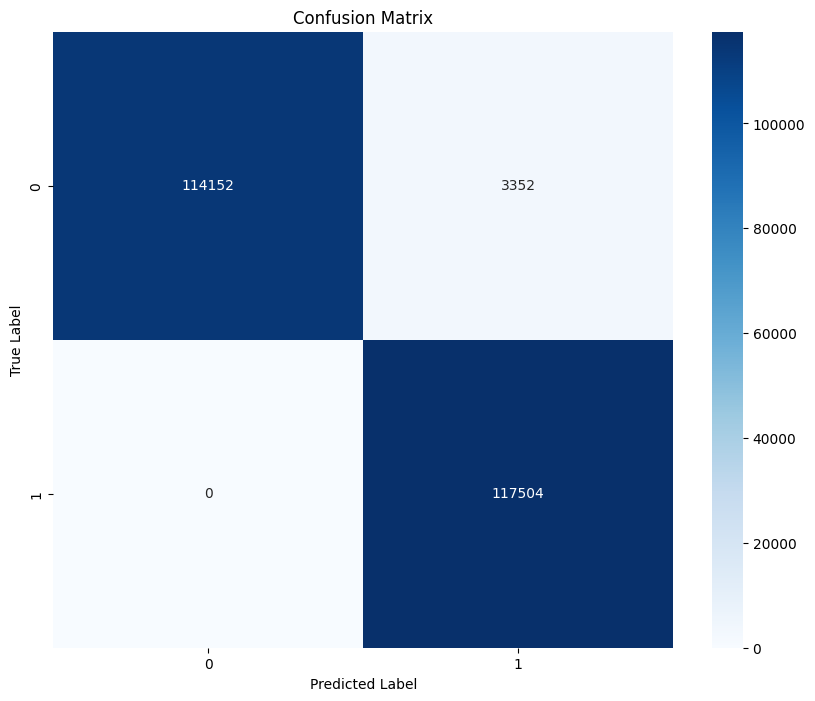

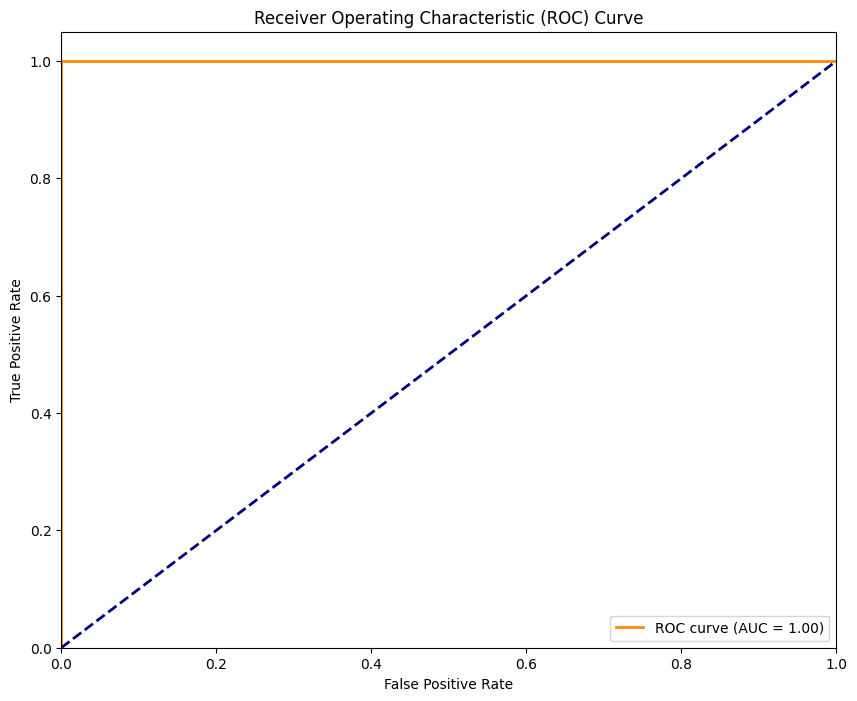

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 1. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 2. ROC Curve & AUC Score
if GPU_AVAILABLE:
    try:
        y_pred_proba = model.predict_proba(X_test_scaled)
        if isinstance(y_pred_proba, cudf.DataFrame):
            y_pred_proba = y_pred_proba.iloc[:, 1].to_numpy()
        else:
            y_pred_proba = y_pred_proba[:, 1].to_numpy()
    except AttributeError:
        # If predict_proba is not available, use predict
        y_pred_proba = model.predict(X_test_scaled).to_numpy()
else:
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# # 3. Feature Importance Plot
# if GPU_AVAILABLE:
#     feature_importance = model.feature_importances_.to_numpy()
# else:
#     feature_importance = model.feature_importances_

# feature_names = X.columns.to_numpy() if GPU_AVAILABLE else X.columns

# # Sort features by importance
# sorted_idx = np.argsort(feature_importance)
# sorted_features = feature_names[sorted_idx]
# sorted_importance = feature_importance[sorted_idx]

# # Plot top 20 features
# plt.figure(figsize=(12, 8))
# plt.barh(range(20), sorted_importance[-20:])
# plt.yticks(range(20), sorted_features[-20:])
# plt.xlabel('Feature Importance')
# plt.title('Top 20 Most Important Features')
# plt.tight_layout()
# plt.show()


In [36]:
# import cudf
# import cupy as cp
# import numpy as np
# import matplotlib.pyplot as plt
# from cuml.metrics import accuracy_score as cu_accuracy_score

# def permutation_importance(model, X, y, n_repeats=10, random_state=42):
#     cp.random.seed(random_state)
    
#     # Ensure y is a 1D array
#     y = y.squeeze() if isinstance(y, cudf.DataFrame) else y
    
#     # Get initial score
#     y_pred = model.predict(X)
#     y_pred = y_pred.squeeze() if isinstance(y_pred, cudf.DataFrame) else y_pred
#     baseline_score = cu_accuracy_score(y, y_pred)
    
#     importances = []
    
#     for col in X.columns:
#         scores = []
#         for _ in range(n_repeats):
#             # Create a copy and shuffle the feature
#             X_shuffled = X.copy()
#             X_shuffled[col] = X_shuffled[col].sample(frac=1.0, replace=False).reset_index(drop=True)
            
#             # Predict and calculate score
#             y_pred = model.predict(X_shuffled)
#             y_pred = y_pred.squeeze() if isinstance(y_pred, cudf.DataFrame) else y_pred
#             score = cu_accuracy_score(y, y_pred)
            
#             # Calculate importance
#             importance = baseline_score - score
#             scores.append(importance)
        
#         importances.append(np.mean(scores))
    
#     return cudf.Series(importances, index=X.columns)


# # Calculate permutation importance
# feature_importance = permutation_importance(model, X_test_scaled, y_test)

# # Convert to CPU for plotting
# feature_importance_cpu = feature_importance.to_pandas()

# # Sort features by importance
# sorted_idx = feature_importance_cpu.argsort()
# sorted_features = feature_importance_cpu.index[sorted_idx]
# sorted_importance = feature_importance_cpu.values[sorted_idx]

# # Determine the number of features to plot (all features if less than 20, otherwise top 20)
# n_features_to_plot = min(len(sorted_features), 20)

# # Plot features
# plt.figure(figsize=(12, 8))
# plt.barh(range(n_features_to_plot), sorted_importance[-n_features_to_plot:])
# plt.yticks(range(n_features_to_plot), sorted_features[-n_features_to_plot:])
# plt.xlabel('Feature Importance (Decrease in Accuracy)')
# plt.title(f'Top {n_features_to_plot} Most Important Features (Permutation Importance)')
# plt.tight_layout()
# plt.show()

# # Print feature importances
# print("Feature Importances:")
# for feature, importance in feature_importance_cpu.sort_values(ascending=False).items():
#     print(f"{feature}: {importance:.4f}")


In [74]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb

# ✅ Detect GPU availability
GPU_AVAILABLE = os.path.exists('/dev/nvidia0')

try:
    if GPU_AVAILABLE:
        import cudf
        import cupy as cp
        from cuml.model_selection import train_test_split as cuml_train_test_split
        from cuml.preprocessing import StandardScaler as cuScaler
        print("🚀 RAPIDS cuML available! Running on GPU")
    else:
        raise ImportError
except ImportError:
    GPU_AVAILABLE = False
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    print("⚡ RAPIDS not available. Running on CPU.")

# 📌 Load dataset directly to GPU
if GPU_AVAILABLE:
    # Assuming df_9 is already loaded as a pandas DataFrame before this block.
    df_10 = cudf.from_pandas(df_9)
else:
    df_10 = df_9.copy()

# Define features and target
X = df_10.drop(columns=['Flag'])
y = df_10['Flag']

# ✅ Handle class imbalance (GPU-compatible)
if GPU_AVAILABLE:
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    X_0_resampled = X_0.sample(n=len(X_1), replace=True)
    X_resampled = cudf.concat([X_1, X_0_resampled])
    y_resampled = cudf.Series(cp.concatenate([cp.ones(len(X_1)), cp.zeros(len(X_0_resampled))]))
else:
    from imblearn.over_sampling import SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

# ✅ Convert cudf DataFrame to NumPy arrays for train_test_split if using GPU
if GPU_AVAILABLE:
    X_resampled_cpu = X_resampled.to_pandas().values  # Convert cudf to pandas, then to NumPy
    y_resampled_cpu = y_resampled.to_pandas().values
else:
    X_resampled_cpu = X_resampled
    y_resampled_cpu = y_resampled

# ✅ Split into train/test sets (works for both CPU and GPU)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled_cpu, y_resampled_cpu, test_size=0.2, random_state=42, stratify=y_resampled_cpu
)

# ✅ Convert back to cudf DataFrame if GPU is available
if GPU_AVAILABLE:
    X_train = cudf.DataFrame.from_pandas(pd.DataFrame(X_train))  # Convert back to cudf DataFrame
    X_test = cudf.DataFrame.from_pandas(pd.DataFrame(X_test))
    y_train = cudf.Series(y_train)
    y_test = cudf.Series(y_test)

# ✅ Convert to float32
if GPU_AVAILABLE:
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')
else:
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)

# ✅ Standardize features
scaler = cuScaler() if GPU_AVAILABLE else StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert columns to explicit string names (FIX HERE)
if GPU_AVAILABLE:
    # For cuDF
    X_train_scaled.columns = X_train_scaled.columns.astype('str')
    X_test_scaled.columns = X_test_scaled.columns.astype('str')
else:
    # For pandas
    X_train_scaled.columns = X_train_scaled.columns.astype(str)
    X_test_scaled.columns = X_test_scaled.columns.astype(str)


# ✅ Choose the model
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "n_estimators": 100,
    "random_state": 42,
    "device": "cuda"
}

if GPU_AVAILABLE:
    print("🚀 Using GPU-Accelerated XGBoost")
    params["tree_method"] = "hist"  # Enable GPU
else:
    print("⚡ Using CPU-based XGBoost")
    params["tree_method"] = "hist"

model = xgb.XGBClassifier(**params)

# ✅ Train the model
model.fit(X_train_scaled, y_train)

# ✅ Predictions and conversion to CPU if necessary
if GPU_AVAILABLE:
    # Predictions are already in NumPy array format, no need for .to_numpy()
    y_pred = model.predict(X_test_scaled)
    # Only convert y_test if it's a cudf Series
    y_test = y_test.to_numpy()  # Convert cudf to NumPy
else:
    y_pred = model.predict(X_test_scaled)  # No conversion needed here either

# ✅ Evaluate the model
from sklearn.metrics import accuracy_score, classification_report
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save model
joblib.dump(model, "xgb_model.joblib")

🚀 RAPIDS cuML available! Running on GPU
🚀 Using GPU-Accelerated XGBoost


/usr/local/lib/python3.10/dist-packages/xgboost/data.py:839: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()


✅ Accuracy: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    117504
         1.0       1.00      1.00      1.00    117504

    accuracy                           1.00    235008
   macro avg       1.00      1.00      1.00    235008
weighted avg       1.00      1.00      1.00    235008



/usr/local/lib/python3.10/dist-packages/xgboost/data.py:839: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()


['xgb_model.joblib']

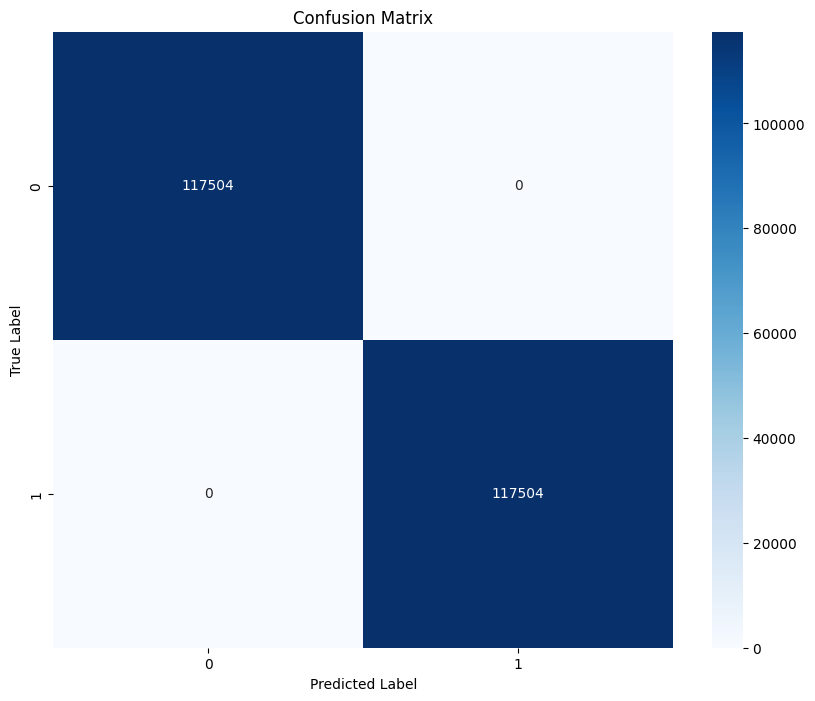

/usr/local/lib/python3.10/dist-packages/xgboost/data.py:839: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()


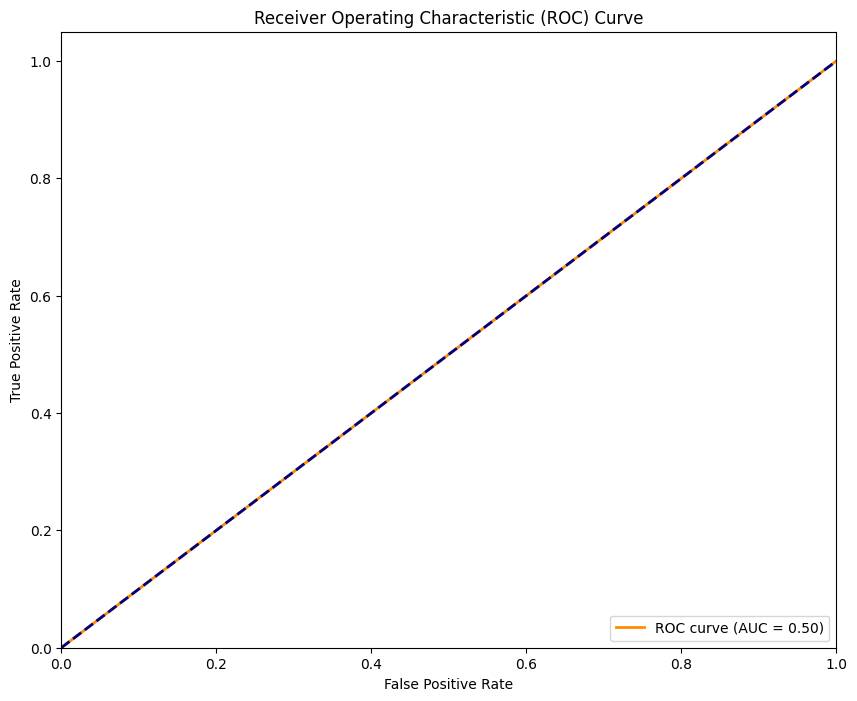

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 1. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 2. ROC Curve & AUC Score
y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# # 3. Feature Importance Plot
# feature_importance = model.feature_importances_
# feature_names = X_train.columns.to_numpy()

# # Sort features by importance
# sorted_idx = np.argsort(feature_importance)
# sorted_features = feature_names[sorted_idx]
# sorted_importance = feature_importance[sorted_idx]

# # Plot top 20 features
# plt.figure(figsize=(12, 8))
# plt.barh(range(20), sorted_importance[-20:])
# plt.yticks(range(20), sorted_features[-20:])
# plt.xlabel('Feature Importance')
# plt.title('Top 20 Most Important Features')
# plt.tight_layout()
# plt.show()
